Supplementary notebook to the manuscript "Unifying thermochemistry concepts in computational heterogeneous catalysis", by Dr. Bjarne Kreitz (Brown University), Dr. Gabriel Gusmao (Georgia Tech), Dr. David H. Bross (Argonne National Laboratory), Dingqi Nai (Georgia Tech), Jagriti Sahoo (Georgia Tech), Dr. C. Franklin Goldsmith (Brown University), Dr. Andrew J. Medford (Georgia Tech). 

Correspondence to Bjarne Kreitz (bjarne_kreitz@brown.edu) and Andrew J. Medford (ajm@gatech.edu)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

eV_to_kJmol=96.485

# Reference QM data to a set of experimental EOF of adsorbates in isodesmic reactions

Enthalpies of formation of adsorbates can be anchored to the existing global thermochemical network of gas-phase species through experimental enthalpies of formation of chosen adsorbates. Instead of using an atomic reference basis set, we can use error cancellation reactions that decompose a target into fragments. Through the conservation of bonding environment and hybridization of the target species in the references, it is possible to construct reactions that maximize the cancellation of errors. The easiest fragmentation based approach is based on a isodesmic reaction, which conserve the number of bonds of the target in the references. All adsorbates that are used in the case study can be broken down into the following 10 bond types C-O, C=C, C=O, C-C, C-H, O-H, Pt-C, Pt#C, Pt=C, Pt-O, where - is a single bond, = double bond, # triple bond. Each bond type can be represented by an adsorbate, for which we need the enthalpy of formation anchored to the global gas-phase thermochemical network. 
Enthalpies of formation of these adsorbates on Pt(111) were derived from experimentally measured heats of adsorption and experimental enthalpies of formation from the ATcT (https://atct.anl.gov/) by Kreitz et al. (https://doi.org/10.1021/acs.jctc.3c00112)


| Bond type | species | $$\Delta_f H\, /\, \text{kJ mol}^{-1}$$ |
|----|--- |----------|  
| Pt#C  | $$^*CH$$ | -35.8  | 
| Pt=C  | $$^*CH_2$$ | 46.5  | 
| Pt-C  | $$^*CH_3$$ | -47.2  | 
| C-H  | $$CH_4^*$$ | -81.3 | 
| C=C  | $$C_2H_4^*$$ | 22.1 | 
| C-C  | $$C_2H_6^*$$ | -96.0 | 
| O-H  | $$H_2O^*$$ | -267.9 | 
| Pt-O  | $$^*OH$$ | -164.7 |
| C=O  | $$H_2CO^*$$ | -159.3 | 
| C-O  | $$CH_3OH^*$$ | -245.0  | 



All species are anchored to the elements in their IUPAC standard states. When anchoring the DFT energies to the global thermochemical network, it is no longer necessary to perform DFT calculations for gas-phase species. Instead, it is possible to simply use the tabulated enthalpies of formation in the ATcT for the gas-phase species as it is in the same reference frame. In our case, we can take known enthalpies of formation for $C_2H_6, C_2H_4, CO, CO_2$. Some of the reference species are also part of the mechanism of the case study and we can use the experimental values directly. For some adsorbates like $^*H$ or $^*CO$ it is not possible to make an isodesmic reaction and we have to use experimental values of the enthalpies of formation directly. 

To determine the enthalpies of formation of the target species with respect to the references in the global thermochemical network, we make a hypothetical reaction to create the target from our references that represent the fragments. 

\begin{equation}
    \nu_{F}\, F \rightarrow P
\end{equation}

The enthalpy of reaction is defined as 
\begin{equation}
\Delta_r H = \Delta_f H_P - \sum_{i}^{N_{reactants}} \nu_i  \Delta_f H_i
\end{equation}

where we know the $\Delta_f H_i$ of the reactants. The equation can be rearranged to determine the enthalpy of formation of the target.

\begin{equation}
\Delta_f H_P  = \Delta_r H + \sum_{i}^{N_{reactants}} \nu_i  \Delta_f H_i
\end{equation}

The enthalpy of reaction can also be computed from the known DFT energies of the target and the reference species. 
\begin{equation}
    \Delta_f H_P = E_{P} - \sum_{i}^{N_{reactants}} \nu_i  E_{i}
\end{equation}

Substituting the enthalpy of reaction leads to the equation to determine the enthalpy of formation of the target with respect to the IUPAC refernence species.

\begin{equation}
\Delta_f H_P  = E_{P} - \sum_{i}^{N_{reactants}} \nu_i  E_{i} + \sum_{i}^{N_{reactants}} \nu_i  \Delta_f H_i
\end{equation}

In matrix notation this reads as

\begin{align}
    \mathbf{\underline{H}}_{f} & =\mathbf{\underline{E}}-\mathbf{\underline{\underline{M}}}\,\mathbf{\underline{E}}^{A} + \mathbf{\underline{\underline{M}}}\,\mathbf{\underline{H}}_{f}^{A}\\
     \mathbf{\underline{H}}_{f} & =\mathbf{\underline{E}}-\mathbf{\underline{\underline{M}}}\,\left(\mathbf{\underline{E}}^{A} - \mathbf{\underline{H}}_{f}^{A}\right)
\end{align}

where $\mathbf{\underline{\underline{M}}}$ can be determined from the bond type matrix of the target species $\mathbf{\underline{\underline{F}}}$ and the reference species $\mathbf{\underline{\underline{F}}}^A$

\begin{equation}
 \mathbf{\underline{\underline{M}}}=\mathbf{\underline{\underline{F}}}\,\mathbf{\underline{\underline{F}}}^{A^{-1}}
\end{equation}


This is the list of species with their DFT energies from BEEF-vdW for which we want to compute the enthalpies of formation. We can create a vector $\mathbf{\underline{E}}$ that contains the energies from this dictionary.

In [3]:
#Target species for which we need to compute the EOFs
#all gas-phase species are removed since we use the ATcT values for the enthalpies of formation
#all adsorbates that are used as reference are removed from the list
#we use experimental values for XH and XCO
species_energies = {
    "XCH2CH3": -378214.9168,
    "XCH2XCH2": -378198.4442,
    "CO2X": -379030.8164,
} #values are in eV

#vector of DFT energies of the target species from the dictionary
E=np.array(list(species_energies.values()))

We want to determine the enthalpies of formation with reference to $[CH_4, H_2, H_2O, Pt(111)]$. For which we determined the DFT energies. We construct the vector $\mathbf{\underline{E}}^{A}$ that contains the DFT energies of the reference species

In [4]:
ref_energies = {
    "CH3OHX": -378517.9494,
    "CH2CH2X": -378197.7339,
    "H2COX": -378484.4684,
    "CH3CH3X": -378231.5655,
    "CH4X": -377940.4907,
    "H2OX": -378227.2801,
    "XCH3": -377923.7364,
    "XCH": -377890.838,
    "XCH2": -377906.9113,
    "XOH": -378209.8045,
}#values are in eV

#vector of DFT energies of the reference species from the dictionary
E_A=np.array(list(ref_energies.values()))

For the reference species we have to collect the enthalpies of formation from the ATcT

In [5]:
ref_EOF = {
    "CH3OHX": -245.0,
    "C2H4X": 22.1,
    "H2COX": -159.3,
    "C2H6X": -96.0,
    "CH4X": -81.3,
    "H2OX": -267.9,
    "XCH3": -47.2,
    "XCH": -35.8,
    "XCH2": 46.5,
    "XOH": -164.7,
}#values are in kJ/mol

H_ref=np.array(list(ref_EOF.values()))

We start now with constructing the elemental composition matrix of our target species $\mathbf{\underline{\underline{N}}}$, which is an $m \times n$ matrix with $m$ target species and $n$ elements. 

In [6]:
# Define the species and their elemental compositions in a dictionary
species_compositions = {
    "XCH2CH3": {"C-O": 0, "C=C": 0, "C=O": 0, "C-C":1, "C-H": 5, "O-H": 0, "Pt-C":1, "Pt#C":0, "Pt=C":0, "Pt-O":0},
    "XCH2XCH2": {"C-O": 0, "C=C": 0, "C=O": 0, "C-C":1, "C-H": 4, "O-H": 0, "Pt-C":2, "Pt#C":0, "Pt=C":0, "Pt-O":0},
    "CO2X": {"C-O": 0, "C=C": 0, "C=O": 2, "C-C":0, "C-H": 0, "O-H": 0, "Pt-C":0, "Pt#C":0, "Pt=C":0, "Pt-O":0},
}

species=list(species_compositions.keys())

# Create a matrix to hold the elemental compositions of the target species
num_species = len(species_compositions)
num_bond_types = 10  # C-O, C=C, C=O, C-C, C-H, O-H, Pt-C, Pt#C, Pt=C, Pt-O
F = np.zeros((num_species, num_bond_types))

# Fill in the elemental composition matrix of the target species
for s, composition in species_compositions.items():
    i = species.index(s)
    F[i, :] = [composition["C-O"], composition["C=C"], composition["C=O"], composition["C-C"],
               composition["C-H"],  composition["O-H"], composition["Pt-C"],
               composition["Pt#C"], composition["Pt=C"], composition["Pt-O"]]
    
F

array([[0., 0., 0., 1., 5., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 4., 0., 2., 0., 0., 0.],
       [0., 0., 2., 0., 0., 0., 0., 0., 0., 0.]])

We construct the elemental composition matrix of our reference species $\mathbf{\underline{\underline{N}}}^A$, which is an $m \times n$ matrix with $m$ reference species and $n$ elements. 

In [7]:
# Define the species and their elemental compositions in a dictionary
references_compositions = {
    "CH3OHX": {"C-O": 1, "C=C": 0, "C=O": 0, "C-C":0, "C-H": 3, "O-H": 1, "Pt-C":0, "Pt#C":0, "Pt=C":0, "Pt-O":0},
    "C2H4X": {"C-O": 0, "C=C": 1, "C=O": 0, "C-C":0, "C-H": 4, "O-H": 0, "Pt-C":0, "Pt#C":0, "Pt=C":0, "Pt-O":0},
    "H2COX": {"C-O": 0, "C=C": 0, "C=O": 1, "C-C":0, "C-H": 2, "O-H": 0, "Pt-C":0, "Pt#C":0, "Pt=C":0, "Pt-O":0},
    "C2H6X": {"C-O": 0, "C=C": 0, "C=O": 0, "C-C":1, "C-H": 6, "O-H": 0, "Pt-C":0, "Pt#C":0, "Pt=C":0, "Pt-O":0},
    "CH4X": {"C-O": 0, "C=C": 0, "C=O": 0, "C-C":0, "C-H": 4, "O-H": 0, "Pt-C":0, "Pt#C":0, "Pt=C":0, "Pt-O":0},
    "H2OX": {"C-O": 0, "C=C": 0, "C=O": 0, "C-C":0, "C-H": 0, "O-H": 2, "Pt-C":0, "Pt#C":0, "Pt=C":0, "Pt-O":0},
    "XCH3": {"C-O": 0, "C=C": 0, "C=O": 0, "C-C":0, "C-H": 3, "O-H": 0, "Pt-C":1, "Pt#C":0, "Pt=C":0, "Pt-O":0},
    "XCH": {"C-O": 0, "C=C": 0, "C=O": 0, "C-C":0, "C-H": 1, "O-H": 0, "Pt-C":0, "Pt#C":1, "Pt=C":0, "Pt-O":0},
    "XCH2": {"C-O": 0, "C=C": 0, "C=O": 0, "C-C":0, "C-H": 2, "O-H": 0, "Pt-C":0, "Pt#C":0, "Pt=C":1, "Pt-O":0},
    "XOH": {"C-O": 0, "C=C": 0, "C=O": 0, "C-C":0, "C-H": 0, "O-H": 1, "Pt-C":0, "Pt#C":0, "Pt=C":0, "Pt-O":1},
}

references=list(references_compositions.keys())

# Create a matrix to hold the elemental compositions of the reference species
num_references = len(references_compositions)
F_A = np.zeros((num_references, num_bond_types))

# Fill in the elemental composition matrix of the reference species
for s, composition in references_compositions.items():
    i = references.index(s)
    F_A[i, :] = [composition["C-O"], composition["C=C"], composition["C=O"], composition["C-C"],
               composition["C-H"],  composition["O-H"], composition["Pt-C"],
               composition["Pt#C"], composition["Pt=C"], composition["Pt-O"]]
    
F_A

array([[1., 0., 0., 0., 3., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 4., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 2., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 6., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 4., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 2., 0., 0., 0., 0.],
       [0., 0., 0., 0., 3., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 2., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]])

We can now determine $\mathbf{\underline{\underline{M}}}$ from the elemental composition matrix of the target species $\mathbf{\underline{\underline{F}}}$ and the reference species $\mathbf{\underline{\underline{F}}}^A$ via

\begin{equation}
 \mathbf{\underline{\underline{M}}}=\mathbf{\underline{\underline{F}}}\,\mathbf{\underline{\underline{F}}}^{A^{-1}}
\end{equation}

In [8]:
#Calculate the matrix of stoichiometric coefficients to form the target from the reference species
M=F.dot(np.linalg.inv(F_A))
M

array([[ 0.,  0.,  0.,  1., -1.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1., -2.,  0.,  2.,  0.,  0.,  0.],
       [ 0.,  0.,  2.,  0., -1.,  0.,  0.,  0.,  0.,  0.]])

The last step is to compute the enthalpies of formation using the matrix of stoichiometric coefficients of the formation reactions and the DFT energies of the target species and references

\begin{equation}
    \mathbf{\underline{H}}_{f} =\mathbf{\underline{E}}-\mathbf{\underline{\underline{M}}}\,\mathbf{\underline{E}}^{A} + \mathbf{\underline{\underline{M}}}\,\mathbf{\underline{H}}_{f}^{A}
\end{equation}

In [9]:
#Determine the enthalpy of formation of the target
Hf=(E*eV_to_kJmol-M.dot(E_A)*eV_to_kJmol+M.dot(H_ref))

#Create a dictionary with the results
enthalpies_of_formation = {species[i]: Hf[i] for i in range(len(species))}
enthalpies_of_formation

{'XCH2CH3': -72.08881599605084,
 'XCH2XCH2': -65.16864050477744,
 'CO2X': -465.99839549809695}

The enthalpies of formation of our reference species are the known values in the ATcT. Pt(111) is denoted as a generic X and assumed to have an enthalpy of formation of 0.

In [10]:
#Append the enthalpies of formation of the reference species to the enthalpies of formation dictionary
enthalpies_of_formation.update({'C2H6': -68.38, 'C2H4': 60.89, 'CO':-113.800, 'CO2':-393.110, 'H2O': -238.929})
enthalpies_of_formation.update(ref_EOF)
enthalpies_of_formation.update({'XCO': -230.9, 'XH':-32.7, 'XO':-103.7})
enthalpies_of_formation

{'XCH2CH3': -72.08881599605084,
 'XCH2XCH2': -65.16864050477744,
 'CO2X': -465.99839549809695,
 'C2H6': -68.38,
 'C2H4': 60.89,
 'CO': -113.8,
 'CO2': -393.11,
 'H2O': -238.929,
 'CH3OHX': -245.0,
 'C2H4X': 22.1,
 'H2COX': -159.3,
 'C2H6X': -96.0,
 'CH4X': -81.3,
 'H2OX': -267.9,
 'XCH3': -47.2,
 'XCH': -35.8,
 'XCH2': 46.5,
 'XOH': -164.7,
 'XCO': -230.9,
 'XH': -32.7,
 'XO': -103.7}

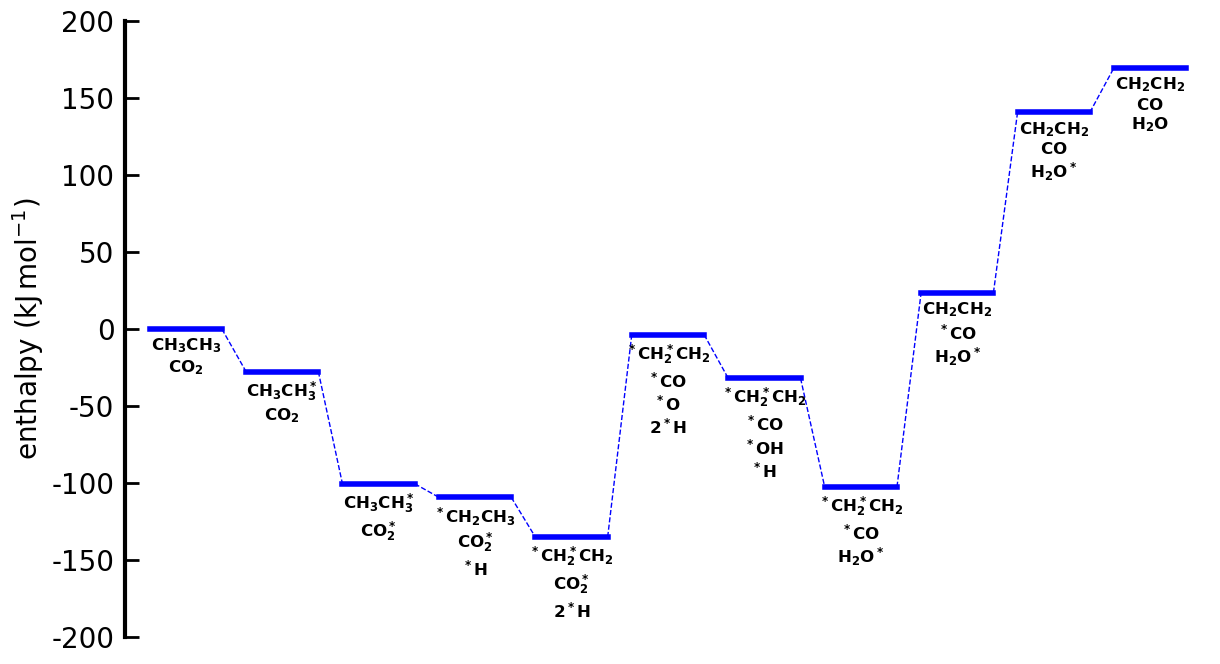

In [11]:
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['axes.linewidth'] = 3
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rcParams['lines.markersize'] = 10
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['legend.edgecolor'] = 'k'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["legend.framealpha"] = 1
plt.rcParams['ytick.major.pad'] = 8


gs = gridspec.GridSpec(nrows=1, ncols=1)
gs.update(wspace=0.5, hspace=0.5)
ax0 = plt.subplot(gs[0, 0])

ax0.set_ylim([-200,200])
ax0.set_xlim([-1,44])
ax0.get_xaxis().set_visible(False)
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.spines['bottom'].set_visible(False)
ax0.set_ylabel('$\mathrm{enthalpy\ (kJ\,mol^{-1})}$')


mechanism=({'C2H6':1,'CO2':1},
    {'C2H6X':1,'CO2':1},
    {'C2H6X':1,'CO2X':1},
    {'XCH2CH3':1,'CO2X':1,'XH':1},
    {'XCH2XCH2':1,'CO2X':1,'XH':2},
    {'XCH2XCH2':1,'XCO':1,'XO':1,'XH':2},
    {'XCH2XCH2':1,'XCO':1,'XOH':1,'XH':1},
    {'XCH2XCH2':1,'XCO':1,'H2OX':1},
    {'C2H4':1,'XCO':1,'H2OX':1},
    {'C2H4':1,'CO':1,'H2OX':1}, 
    {'C2H4':1,'CO':1,'H2O':1},
    )

tags=('$\mathbf{CH_3CH_3}$\n$\mathbf{CO_2}$',
      '$\mathbf{CH_3CH_3^*}$\n$\mathbf{CO_2}$',
      '$\mathbf{CH_3CH_3^*}$\n$\mathbf{CO_2^*}$',
      '$\mathbf{^*CH_2CH_3}$\n$\mathbf{CO_2^*}$\n$\mathbf{^*H}$',
      '$\mathbf{^*CH_2^*CH_2}$\n$\mathbf{CO_2^*}$\n$\mathbf{2 ^*H}$',
      '$\mathbf{^*CH_2^*CH_2}$\n$\mathbf{^*CO}$\n$\mathbf{^*O}$\n$\mathbf{2 ^*H}$',
      '$\mathbf{^*CH_2^*CH_2}$\n$\mathbf{^*CO}$\n$\mathbf{^*OH}$\n$\mathbf{^*H}$',
      '$\mathbf{^*CH_2^*CH_2}$\n$\mathbf{^*CO}$\n$\mathbf{H_2O^*}$',
      '$\mathbf{CH_2CH_2}$\n$\mathbf{^*CO}$\n$\mathbf{H_2O^*}$',
      '$\mathbf{CH_2CH_2}$\n$\mathbf{CO}$\n$\mathbf{H_2O^*}$',
      '$\mathbf{CH_2CH_2}$\n$\mathbf{CO}$\n$\mathbf{H_2O}$',
)

# Function to compute the sum for each step in the mechanism
def compute_sum(vec,dictionary):
    return sum(vec[key] * value for key, value in dictionary.items())

def ediagram(ref_system):
    system = [compute_sum(ref_system,entry) for entry in mechanism]
    rel_EOFs=np.zeros(len(system))
    for i, Hf_i in enumerate(system):
        start = i * 4
        end = start + 3
        ax0.plot((start, end), (Hf_i-system[0], Hf_i-system[0]), linestyle='solid', color='b')
        if i>0:
            ax0.plot((start-1,start),(system[i-1]-system[0],Hf_i-system[0]),linestyle='dashed',color='b', linewidth=1)
        rel_EOFs[i]=Hf_i-system[0]
    return rel_EOFs

values=ediagram(enthalpies_of_formation)

for i in range(len(np.array(values).T)):
    start = i * 4
    ax0.text(start+1.5,np.array(values).T[i]-5,tags[i],va='top',ha='center',size=12)